In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/UTKFace.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [3]:
import os
import shutil

# Chemin vers le dossier UTKFace
utkface_folder = "/content/UTKFace"

# Créer un dossier de sortie
output_folder = "/content/UTKFaceN"
os.makedirs(output_folder, exist_ok=True)

# Définir les âges pour lesquels vous voulez collecter des images
ages_to_collect = list(range(1, 101))

# Nombre d'images à collecter par âge
images_per_age = 45

# Parcourir tous les fichiers dans le dossier UTKFace
for filename in os.listdir(utkface_folder):
    # Extraire l'âge du nom de fichier
    age = int(filename.split('_')[0])

    # Vérifier si l'âge est dans la liste des âges à collecter
    if age in ages_to_collect:
        # Copier le fichier dans le dossier UTKFaceM
        source_path = os.path.join(utkface_folder, filename)
        destination_path = os.path.join(output_folder, filename)
        shutil.copyfile(source_path, destination_path)

        # Décrémenter le nombre d'images à collecter pour cet âge
        images_per_age -= 1

        # Vérifier si vous avez collecté suffisamment d'images pour cet âge
        if images_per_age == 0:
            ages_to_collect.remove(age)
            images_per_age = 40  # Réinitialiser le nombre d'images à collecter pour le prochain âge

        if not ages_to_collect:
            break


In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Fonction de défloutage
def deblur_image(image):
    # Appliquer un filtre de déconvolution (inverse du filtre de flou gaussien)
    kernel = np.ones((5, 5), np.float32) / 25
    deblurred_image = cv2.filter2D(image, -1, kernel)
    return deblurred_image

# 1. Explorer la structure du jeu de données
data_path = "/content/UTKFaceN"
images = []
labels = []

for filename in os.listdir(data_path):
    if filename.endswith(".jpg"):
        # Les noms de fichiers dans UTKFace sont formatés comme "âge_genre_date_heure_minute_seconde.jpg"
        age = int(filename.split('_')[0])
        labels.append(age)
        img_path = os.path.join(data_path, filename)
        img = cv2.imread(img_path)
        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        # Ajout de prétraitements pour réduire le bruit
        img = cv2.resize(img, (224, 224))  # Redimensionner les images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir l'image en format RGB
        img = deblur_image(img)  # Appliquer le défloutage

        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        images.append(img)

# Convertir les listes en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

# 2. Diviser le jeu de données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Normaliser les images (mise à l'échelle des pixels entre 0 et 1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Charger le modèle VGG16 pré-entraîné (poids ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées pour la prédiction de l'âge
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='linear')(x)  # Activation linéaire pour la prédiction de l'âge

# Créer le modèle complet
model = models.Model(inputs=base_model.input, outputs=output)

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Afficher un résumé du modèle
print(model.summary())


58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

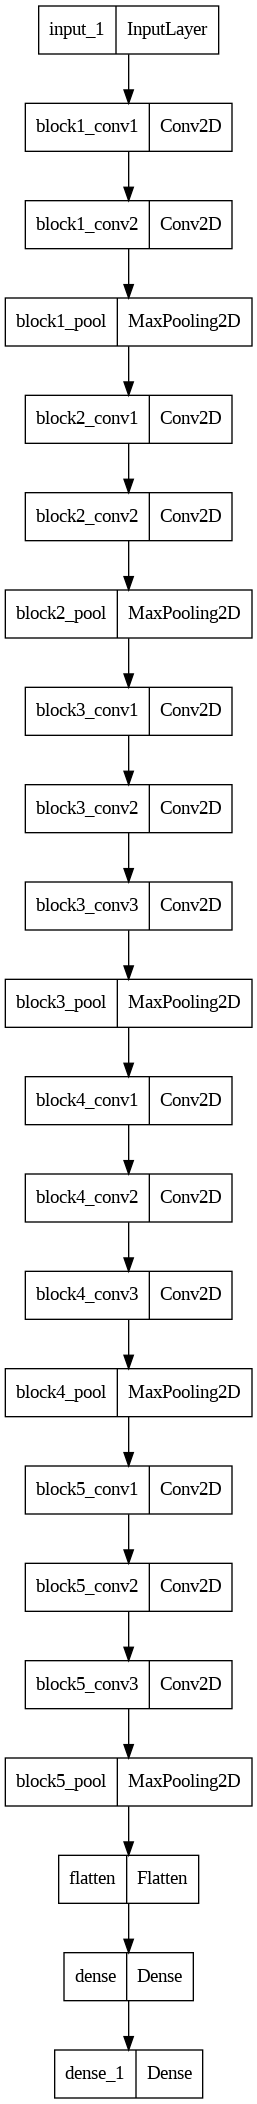

In [6]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [7]:
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=70)

Epoch 1/70
72/72 [==============================] - 26s 215ms/step - loss: 473.8152 - mae: 17.3469 - val_loss: 286.0408 - val_mae: 13.4536
Epoch 2/70
72/72 [==============================] - 11s 149ms/step - loss: 243.6497 - mae: 12.4336 - val_loss: 241.6530 - val_mae: 12.1656
Epoch 3/70
72/72 [==============================] - 11s 152ms/step - loss: 187.0267 - mae: 10.6672 - val_loss: 221.9289 - val_mae: 11.4739
Epoch 4/70
72/72 [==============================] - 12s 163ms/step - loss: 155.8705 - mae: 9.6205 - val_loss: 206.0531 - val_mae: 10.9612
Epoch 5/70
72/72 [==============================] - 12s 165ms/step - loss: 129.3533 - mae: 8.6963 - val_loss: 215.9189 - val_mae: 11.3281
Epoch 6/70
72/72 [==============================] - 11s 159ms/step - loss: 112.4046 - mae: 8.1030 - val_loss: 194.6443 - val_mae: 10.6653
Epoch 7/70
72/72 [==============================] - 11s 159ms/step - loss: 100.3445 - mae: 7.6541 - val_loss: 218.2486 - val_mae: 11.4449
Epoch 8/70
72/72 [=============

In [8]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

16/16 [==============================] - 2s 124ms/step - loss: 199.5441 - mae: 10.6200
Test Loss: 199.54412841796875, Test MAE: 10.61996078491211


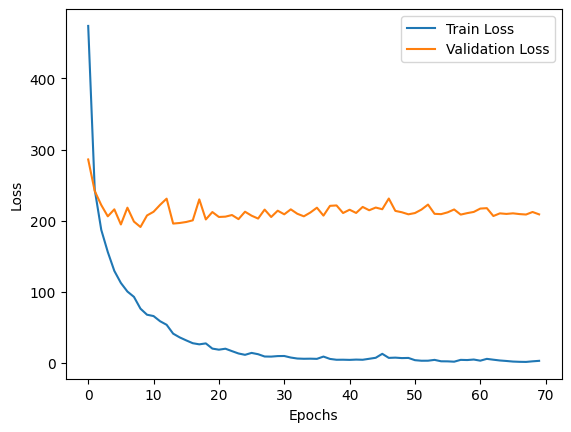

In [9]:
import matplotlib.pyplot as plt

# Afficher les courbes d'apprentissage
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
predictions = model.predict(X_test)
# Afficher les vrais âges et les prédictions sous forme de tableau
comparison_table = np.column_stack((y_test, predictions.flatten()))
print("Vrais Âges vs Prédictions d'Âge :\n", comparison_table)

16/16 [==============================] - 2s 124ms/step
Vrais Âges vs Prédictions d'Âge :
 [[ 3.70000000e+01  1.69878178e+01]
 [ 3.70000000e+01  3.99486961e+01]
 [ 7.60000000e+01  4.45223999e+01]
 [ 4.20000000e+01  7.13550034e+01]
 [ 7.30000000e+01  6.66991959e+01]
 [ 2.60000000e+01  3.52887001e+01]
 [ 4.40000000e+01  4.85059204e+01]
 [ 8.50000000e+01  6.65950394e+01]
 [ 1.00000000e+00  2.55022430e+00]
 [ 6.40000000e+01  5.56393127e+01]
 [ 1.00000000e+01  2.38688507e+01]
 [ 1.90000000e+01  2.08597240e+01]
 [ 7.60000000e+01  4.52138367e+01]
 [ 3.10000000e+01  3.06464653e+01]
 [ 7.90000000e+01  5.85119820e+01]
 [ 8.90000000e+01  7.50858994e+01]
 [ 4.80000000e+01  7.05152206e+01]
 [ 3.00000000e+01  2.62684879e+01]
 [ 6.60000000e+01  7.84137344e+01]
 [ 3.20000000e+01  2.20999775e+01]
 [ 1.10000000e+01  6.94082594e+00]
 [ 4.30000000e+01  4.51767235e+01]
 [ 9.00000000e+00  1.21835804e+01]
 [ 1.50000000e+01  1.63211784e+01]
 [ 4.00000000e+00  7.91282511e+00]
 [ 1.50000000e+01  8.98358822e+00]


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcul des métriques
mae = mean_absolute_error(y_test, predictions.flatten())
mse = mean_squared_error(y_test, predictions.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions.flatten())

# Affichage des résultats
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

MAE: 10.62
MSE: 199.54
RMSE: 14.13
R^2: 0.71


In [12]:
tolerance = 10  # La fourchette acceptable autour de l'âge réel

# Calculer la précision
correct_predictions = np.sum(np.abs(y_test - predictions.flatten()) <= tolerance)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions

# Afficher la précision
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 57.99%


In [13]:
model.save("/content/drive/MyDrive/CV/VGG_16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step
Prédiction d'âge : 51.2189826965332 ans


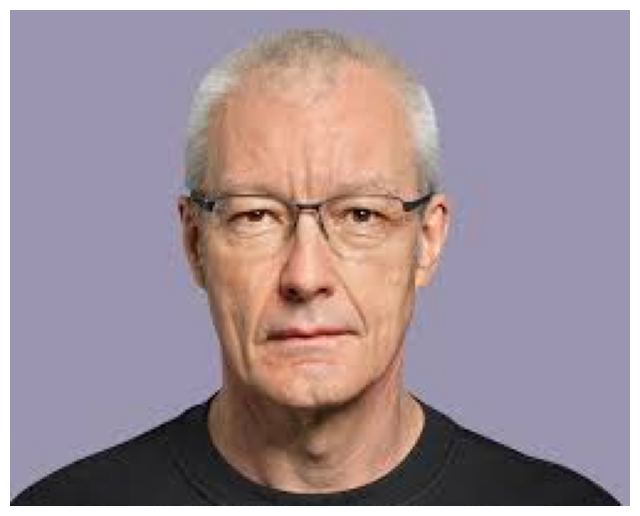

In [17]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model



# Charger et prétraiter l'image que vous souhaitez tester
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Assurez-vous de redimensionner l'image selon les spécifications de votre modèle
    img = img / 255.0  # Normalisation des pixels
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour représenter le lot (batch)
    return img

# Chemin de l'image que vous souhaitez tester
image_path = '/content/homme.jpeg'

# Prétraiter l'image
processed_image = preprocess_image(image_path)

# Faire une prédiction avec le modèle
prediction = model.predict(processed_image)

# Afficher la prédiction
predicted_age = prediction[0][0]
print(f"Prédiction d'âge : {predicted_age} ans")
# Charger à nouveau l'image pour l'affichage
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Afficher l'image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 26ms/step
Prédiction d'âge : 120.81761932373047 ans


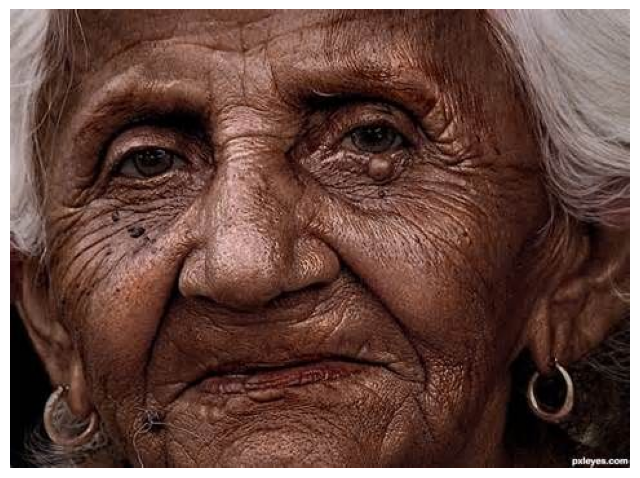

In [19]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model



# Charger et prétraiter l'image que vous souhaitez tester
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Assurez-vous de redimensionner l'image selon les spécifications de votre modèle
    img = img / 255.0  # Normalisation des pixels
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour représenter le lot (batch)
    return img

# Chemin de l'image que vous souhaitez tester
image_path = '/content/dame.jpg'

# Prétraiter l'image
processed_image = preprocess_image(image_path)

# Faire une prédiction avec le modèle
prediction = model.predict(processed_image)

# Afficher la prédiction
predicted_age = prediction[0][0]
print(f"Prédiction d'âge : {predicted_age} ans")
# Charger à nouveau l'image pour l'affichage
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Afficher l'image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 132ms/step
Prédiction d'âge : 16.561128616333008 ans


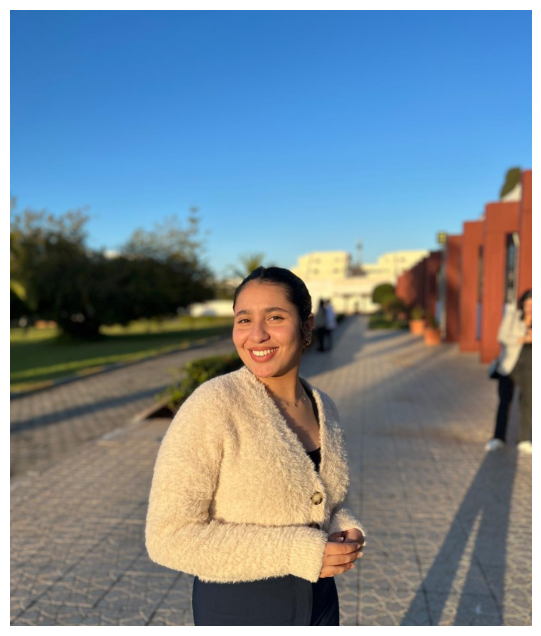

In [22]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model



# Charger et prétraiter l'image que vous souhaitez tester
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Assurez-vous de redimensionner l'image selon les spécifications de votre modèle
    img = img / 255.0  # Normalisation des pixels
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour représenter le lot (batch)
    return img

# Chemin de l'image que vous souhaitez tester
image_path = '/content/habiba.jpg'

# Prétraiter l'image
processed_image = preprocess_image(image_path)

# Faire une prédiction avec le modèle
prediction = model.predict(processed_image)

# Afficher la prédiction
predicted_age = prediction[0][0]
print(f"Prédiction d'âge : {predicted_age} ans")
# Charger à nouveau l'image pour l'affichage
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Afficher l'image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
import tensorflow as tf

# Chargement d'un modèle pré-entraîné
modelVGG = tf.keras.models.load_model('/content/drive/MyDrive/CV/VGG_16.h5')

1/1 [==============================] - 4s 4s/step


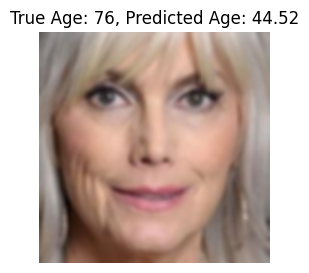

In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt


  # Redimensionner l'image pour qu'elle ait la forme attendue
resized_image = tf.image.resize(X_test[2], (224, 224))
resized_image = np.expand_dims(resized_image, axis=0)  # Ajouter la dimension de lot

plt.figure(figsize=(3, 3))  # Nouvelle taille de figure
plt.imshow(X_test[2])
true_age = y_test[2]

    # Faire la prédiction avec l'image redimensionnée
prediction = modelVGG.predict(resized_image)
predicted_age = prediction[0, 0]

plt.title(f'True Age: {true_age}, Predicted Age: {predicted_age:.2f}')
plt.axis('off')
plt.show()